# Analyzing neuropil signals in the mice 
* 10/9/23 setup
* 10/16/23 migrating to `sleep` repo and stripping of sima stuff
* 10/18/23 kinda works for a sinle mouse

In [1]:
import sys, os
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
import scipy.signal as signal

sys.path.append('/home/gergely/code/sleep/base/')

from suite2p_class import Suite2p
from mouse_class import Mouse
from eeg_class import eegData
from behavior_class import behaviorData

def freq_calc(data: pd.Series, fs: int=10):
    """data: npil_eeg data"""
    frequencies, psd = signal.welch(data, fs=fs, detrend='linear')    
    return frequencies, psd

In [ ]:
mice  =[
    '5HT2afl05b_1', 
    '5HT2afl05b_2',
    'sert52b_1',
    'sert52b_5',
    'sert54a_5'
    ]

In [ ]:
mouse = Mouse(mice[0])
mouse.mouse_id

In [ ]:
s2p_mouse = Suite2p(mouse.mouse_id)
s2p_folders = s2p_mouse.s2p_folders
for folders in enumerate(s2p_folders):
    print(folders)

In [ ]:
s2p_folder = s2p_folders[9]
sima_folder = os.path.dirname(s2p_folder)
sima_folder

In [2]:
sima_folders = [
    '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC1-001/TSeries-07072021-0833_GC1-001_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_GC2-003/TSeries-07072021-0833_GC2-003_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC1-002/TSeries-07072021-0833_MC1-002_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_1/7_7_SD/TSeries-07072021-0833_MC2-004/TSeries-07072021-0833_MC2-004_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_GC-001/TSeries-07062021-0844_GC-001_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC-002/TSeries-07062021-0844_MC-002_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/5HT2afl05b_2/7_6_SD/TSeries-07062021-0844_MC2-004/TSeries-07062021-0844_MC2-004_Cycle00001_Element00001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert52b_5/4_3_SD/TSeries-04032023-1323-001/TSeries-04032023-1323-001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert54a_5/4_4/TSeries-04042023-1023_sess1-001/TSeries-04042023-1023_sess1-001.sima',
                '/data2/gergely/invivo_DATA/sleep/sert52b_1/4_3_SD/TSeries-04032023-1323_SD_sess1-001/TSeries-04032023-1323_SD_sess1-001.sima'
                ]

In [127]:
file_name = join(sima_folder, 'eeg', 'velo_eeg.csv' )
eeg_velo = eegData.load_processed_velocity_eeg(file_name = file_name)

eeg_velo['mobile_immobile'] = behaviorData.define_immobility(eeg_velo['filtered velo'])
eeg_velo

,Frames,filtered velo,score,awake,NREM,REM,other,mobile_immobile
0,0.0,0.0,0,True,False,False,False,False
1,1.0,0.0,0,True,False,False,False,False
2,2.0,0.0,0,True,False,False,False,False
3,3.0,0.0,0,True,False,False,False,False
4,4.0,0.0,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...
24751,24751.0,0.0,0,True,False,False,False,False
24752,24752.0,0.0,0,True,False,False,False,False
24753,24753.0,0.0,0,True,False,False,False,False
24754,24754.0,0.0,0,True,False,False,False,False


In [128]:
df = eegData.brain_state_filter(velo_eeg_df=eeg_velo,
                             states=['awake_mobile', 'awake_immobile', 'NREM', 'REM', 'other'])
df

,awake_mobile,awake_immobile,NREM,REM,other
0,False,True,False,False,False
1,False,True,False,False,False
2,False,True,False,False,False
3,False,True,False,False,False
4,False,True,False,False,False
...,...,...,...,...,...
24751,False,True,False,False,False
24752,False,True,False,False,False
24753,False,True,False,False,False
24754,False,True,False,False,False


Found combined folder


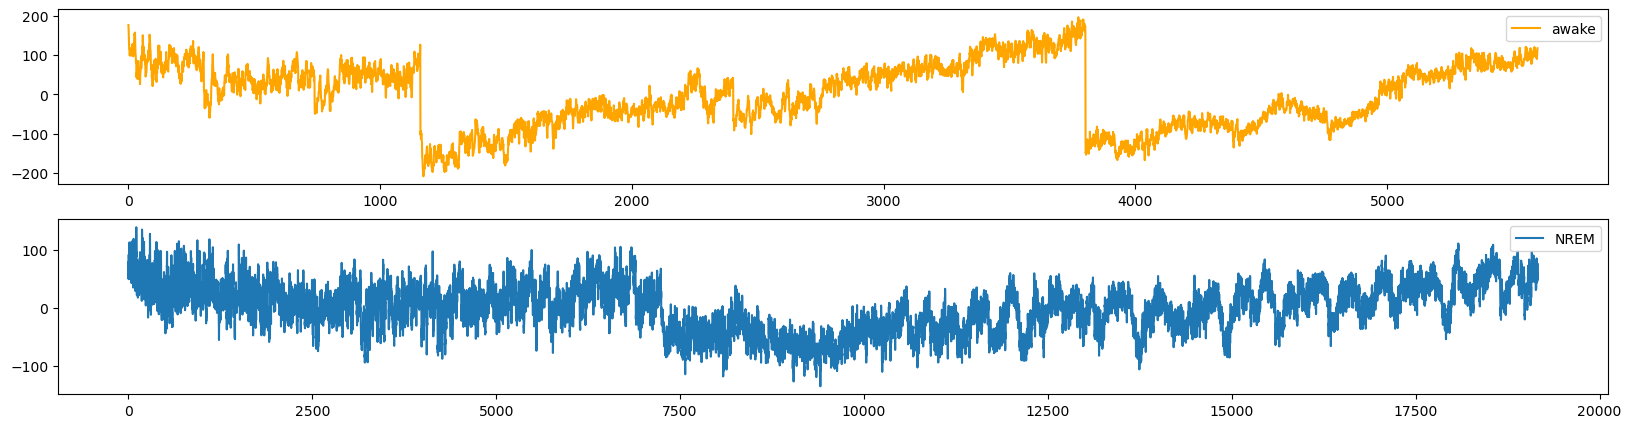

In [130]:
cells = Suite2p.true_cells(s2p_folder)
# cells = s2p_mouse.true_cells(s2p_folder)
mean_cellF = pd.DataFrame(cells.mean(axis=0))
mean_cellF
fig, ax = plt.subplots(nrows=2, figsize=(20,5))
ax[0].plot(signal.detrend(mean_cellF[~df['NREM']], axis=0, 
                          type='linear'), color='orange', label='awake')
ax[0].legend(loc='upper right', labelcolor='k')
ax[1].plot(signal.detrend(mean_cellF[df['NREM']], axis=0,
                          type='linear'))
ax[1].legend(['NREM'], loc='upper right', labelcolor='k')
plt.show()
fig.savefig(join(sima_folder, 'NREM Awake Mean cell traces.png'), 
            bbox_inches='tight', dpi=300)

Found combined folder


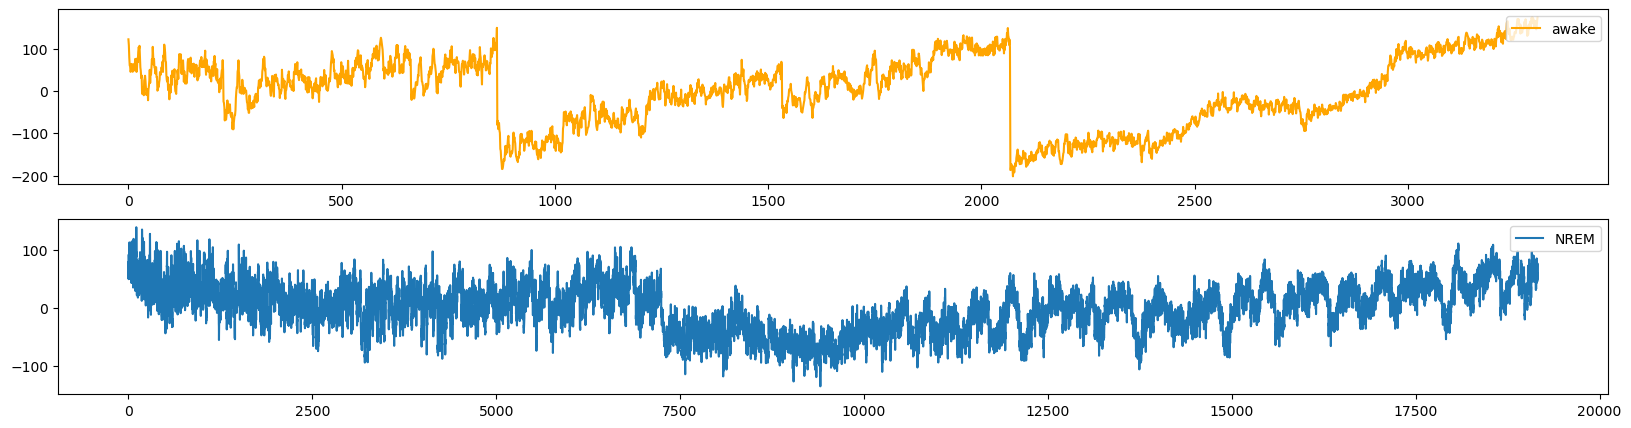

In [131]:
cells = Suite2p.true_cells(s2p_folder)
mean_cellF = pd.DataFrame(cells.mean(axis=0))
mean_cellF
fig, ax = plt.subplots(nrows=2, figsize=(20,5))
ax[0].plot(signal.detrend(mean_cellF[df['awake_immobile']], axis=0, 
                          type='linear'), color='orange', label='awake')
ax[0].legend(loc='upper right', labelcolor='k')
ax[1].plot(signal.detrend(mean_cellF[df['NREM']], axis=0,
                          type='linear'))
ax[1].legend(['NREM'], loc='upper right', labelcolor='k')
plt.show()
fig.savefig(join(sima_folder, 'NREM Awake_immob Mean cell traces.png'), 
            bbox_inches='tight', dpi=300)

Found combined folder


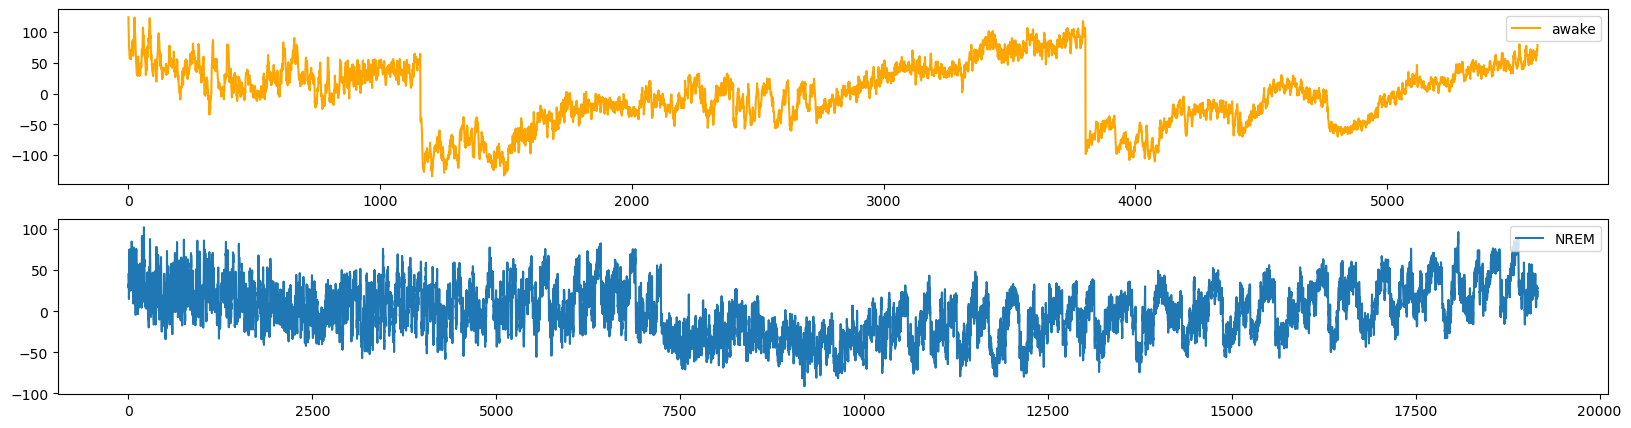

In [132]:
cells = Suite2p.true_npil(s2p_folder)
mean_npilF = pd.DataFrame(cells.mean(axis=0))
mean_npilF
fig, ax = plt.subplots(nrows=2, figsize=(20,5))
ax[0].plot(signal.detrend(mean_npilF[~df['NREM']], axis=0,
                          type='linear'), color='orange', label='awake')
ax[0].legend(loc='upper right', labelcolor='k')
ax[0].legend(labelcolor='k')
ax[1].plot(signal.detrend(mean_npilF[df['NREM']], axis=0,
                          type='linear'), label='NREM')
ax[1].legend(['NREM'], loc='upper right', labelcolor='k')
plt.show()
fig.savefig(join(sima_folder, 'NREM Awake Mean npil traces.png'), 
            bbox_inches='tight', dpi=300)

Found combined folder


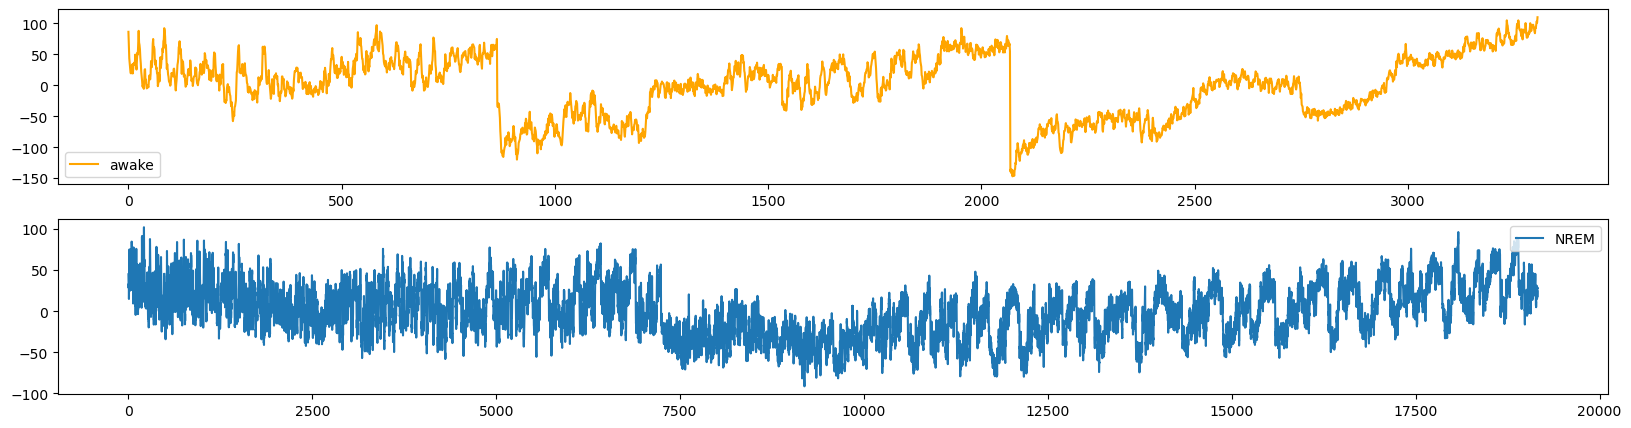

In [133]:
cells = Suite2p.true_npil(s2p_folder)
mean_npilF = pd.DataFrame(cells.mean(axis=0))
mean_npilF
fig, ax = plt.subplots(nrows=2, figsize=(20,5))
ax[0].plot(signal.detrend(mean_npilF[df['awake_immobile']], axis=0,
                          type='linear'), color='orange', label='awake')
ax[0].legend(loc='upper right', labelcolor='k')
ax[0].legend(labelcolor='k')
ax[1].plot(signal.detrend(mean_npilF[df['NREM']], axis=0,
                          type='linear'), label='NREM')
ax[1].legend(['NREM'], loc='upper right', labelcolor='k')
plt.show()
fig.savefig(join(sima_folder, 'NREM Awake_immob Mean npil traces.png'), 
            bbox_inches='tight', dpi=300)

In [134]:
input_data = {
'nrem_cell': pd.Series(mean_cellF.loc[df['NREM'], 0]),
'nrem_npil' : pd.Series(mean_npilF.loc[df['NREM'], 0]),
'awake_npil' : pd.Series(mean_npilF.loc[df['awake_immobile'], 0]),
'awake_cell' : pd.Series(mean_cellF.loc[df['awake_immobile'], 0])
}

In [135]:
results = {}

for key, value in input_data.items():
    freq, psd = freq_calc(value)
    results[key] = {'freq': freq, 'psd': psd}

results.keys()

dict_keys(['nrem_cell', 'nrem_npil', 'awake_npil', 'awake_cell'])

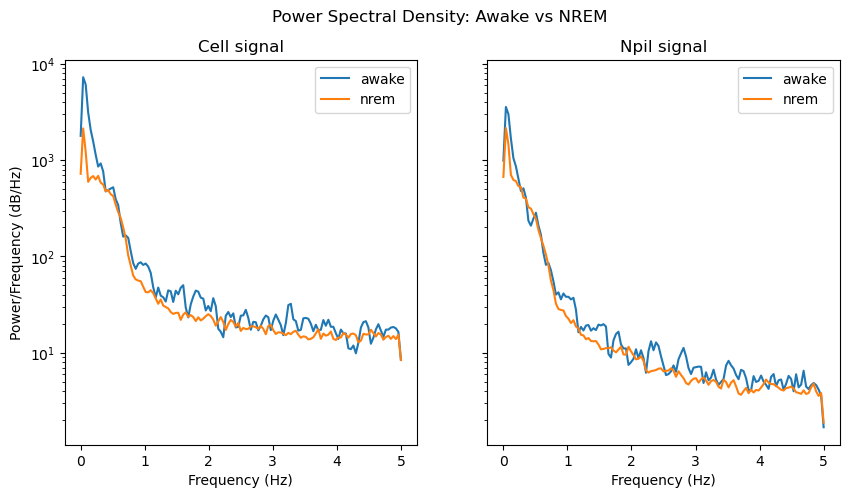

In [136]:
# Create a figure with 2 subplots in 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle('Power Spectral Density: Awake vs NREM')

# Plot the first semilogy plot in the first subplot
axs[0].semilogy(results['awake_cell']['freq'], results['awake_cell']['psd'], label='awake')
axs[0].semilogy(results['nrem_cell']['freq'], results['nrem_cell']['psd'], label='nrem')
axs[0].legend()

# Plot the second semilogy plot in the first subplot
axs[1].semilogy(results['awake_npil']['freq'], results['awake_npil']['psd'], label='awake')
axs[1].semilogy(results['nrem_npil']['freq'], results['nrem_npil']['psd'], label='nrem')
axs[1].legend()

# Set the title and axis labels for the first subplot
axs[0].set_title('Cell signal')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power/Frequency (dB/Hz)')

# Set the title and axis labels for the second subplot
axs[1].set_title('Npil signal')
axs[1].set_xlabel('Frequency (Hz)')

# Show the plot
plt.show()
fig.savefig(join(sima_folder, 'PSD plot cell vs npil.png'), 
            bbox_inches='tight', dpi=300)

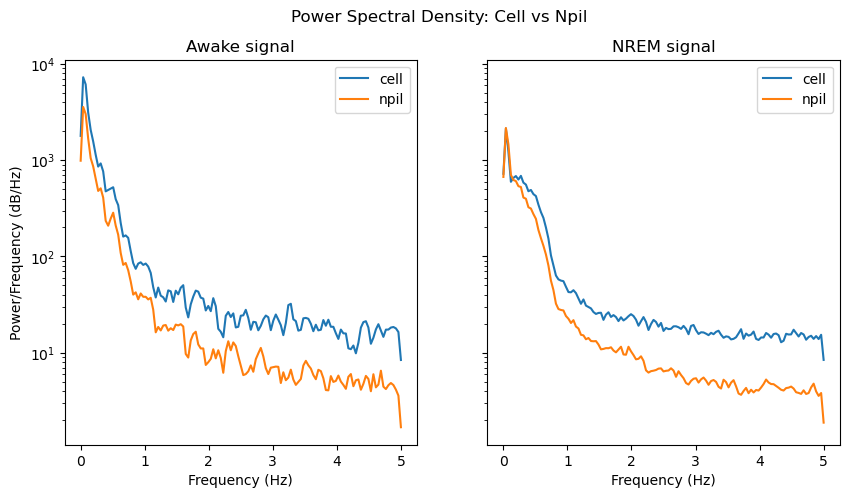

In [137]:
# Create a figure with 2 subplots in 1 row and 2 columns
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.suptitle('Power Spectral Density: Cell vs Npil')

# Plot the first semilogy plot in the first subplot
axs[0].semilogy(results['awake_cell']['freq'], results['awake_cell']['psd'], label='cell')
axs[0].semilogy(results['awake_npil']['freq'], results['awake_npil']['psd'], label='npil')
axs[0].legend()

# Plot the second semilogy plot in the first subplot
axs[1].semilogy(results['nrem_cell']['freq'], results['nrem_cell']['psd'], label='cell')
axs[1].semilogy(results['nrem_npil']['freq'], results['nrem_npil']['psd'], label='npil')
axs[1].legend()

# Set the title and axis labels for the first subplot
axs[0].set_title('Awake signal')
axs[0].set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power/Frequency (dB/Hz)')

# Set the title and axis labels for the second subplot
axs[1].set_title('NREM signal')
axs[1].set_xlabel('Frequency (Hz)')

# Show the plot
plt.show()
fig.savefig(join(sima_folder, 'PSD plot awake vs NREM.png'), 
            bbox_inches='tight', dpi=300)